In [1]:
%matplotlib notebook
#NOTA:
# Manylinux1 wheels have been used on the system, making *numpy* implementation underperforming by ~20%

In [2]:
import sys
print(sys.version)
import platform
print(platform.system())

3.5.3 (default, Jan 19 2017, 14:11:04) 
[GCC 6.3.0 20170118]
Linux


In [3]:
!uname -r
!lscpu
!free

4.16.0-0.bpo.2-amd64
Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                16
On-line CPU(s) list:   0-15
Thread(s) per core:    1
Core(s) per socket:    8
Socket(s):             2
NUMA node(s):          2
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 85
Model name:            Intel(R) Xeon(R) Gold 6134 CPU @ 3.20GHz
Stepping:              4
CPU MHz:               1200.142
BogoMIPS:              6400.00
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              1024K
L3 cache:              25344K
NUMA node0 CPU(s):     0,2,4,6,8,10,12,14
NUMA node1 CPU(s):     1,3,5,7,9,11,13,15
Flags:                 fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid ape

In [4]:
!pip freeze|grep numpy
!pip freeze|grep numexpr
!pip freeze|grep numba
!pip freeze|grep pythran
!pip freeze|grep Cython

numpy==1.15.1
numpydoc==0.7.0
numexpr==2.6.8
numba==0.40.1
pythran==0.9.0
Cython==0.29


In [5]:
import math
import cmath
import numpy as np
import numba as nb
import numexpr as ne
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from time import time
H = 0 #Miller index of reflection
K = 4 #Miller index of reflection
N = 100 #Number of units cells per direction
oversampling = 6 #Defines how much points are needed to describe a single Laue fringe (2 = Nyquist frequency)
e0 = 0.1 #Maximum strain at surface
w = 20 #Depth of strain profile below the surface

In [6]:
#Generate real and reciprocal space coordinates
n = np.arange(N)
m = np.arange(N)
h = np.arange(H-0.5, H+0.5, 1./(oversampling*N))
k = np.arange(K-0.5, K+0.5, 1./(oversampling*N))

In [7]:
def Laue_python(n, m, h, k):
    result = [[0 for x in range(len(h))] for y in range(len(k))]
    for i_h in range(len(h)): #loop over the reciprocal space coordinates
        for i_k in range(len(k)):
            for i_n in n:
                for i_m in m:#loop and sum over unit-cells
                    result[i_h][i_k] += cmath.exp(2j*np.pi*(h[i_h]*i_n +k[i_k]*i_m))
            result[i_h][i_k] = abs(result[i_h][i_k])**2
    return result

#Compute and measure
%time  intensity = Laue_python(n, m, h, k)

CPU times: user 47min 54s, sys: 2.14 s, total: 47min 57s
Wall time: 48min 58s


<IPython.core.display.Javascript object>


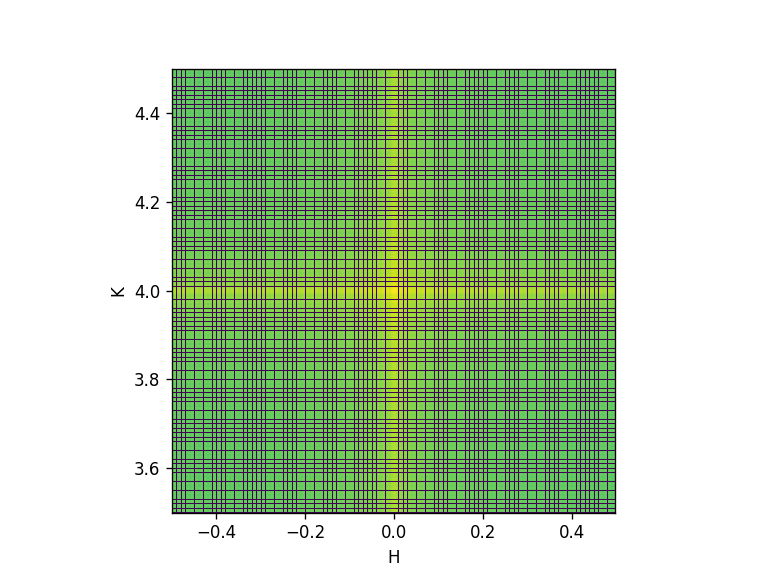

In [8]:
plt.imshow(intensity, extent=(h.min(), h.max(), k.min(), k.max()), norm=LogNorm(), origin = 'lower')
plt.xlabel('H')
plt.ylabel('K')
plt.show()

In [9]:
ref_intensity = intensity

In [10]:
def Laue_python2(n, m, h, k):
    result = [[0 for x in range(len(h))] for y in range(len(k))]
    for i_h in range(len(h)): #loop over the reciprocal space coordinates
        for i_k in range(len(k)):
            tmp = 0.0
            for i_n in n:
                for i_m in n:#loop and sum over unit-cells
                    tmp += cmath.exp(2j*np.pi*(h[i_h]*i_n +k[i_k]*i_m))
            result[i_h][i_k] = abs(tmp)**2
    return result

#Compute and plot
%time  intensity = Laue_python2(n, m, h, k)
print("Error:", abs(np.array(intensity)-np.array(ref_intensity)).max())

CPU times: user 43min 55s, sys: 2.17 s, total: 43min 57s
Wall time: 45min 36s
Error: 0.0


In [11]:
def Laue_hybrid(n, m, h, k):
    result = [[0 for x in range(len(h))] for y in range(len(k))]
    n=np.atleast_2d(n)
    m=np.atleast_2d(m).T
    for i_h, v_h in enumerate(h): #loop over the reciprocal space coordinates
        for i_k, v_k in enumerate(k):
            tmp = np.exp(2j*np.pi*(v_h*n + v_k*m)).sum()
            result[i_h][i_k] = tmp.real**2 + tmp.imag**2
    return result

#Compute and plot
%time  intensity = Laue_hybrid(n, m, h, k)
print("Error:", abs(np.array(intensity)-np.array(ref_intensity)).max())

CPU times: user 4min 14s, sys: 12 ms, total: 4min 14s
Wall time: 4min 39s
Error: 1.2218952178955078e-06


In [12]:
def Laue_numpy(n, m, h, k):
    k = k[:, np.newaxis]
    n = n[:, np.newaxis, np.newaxis]
    m = m[:, np.newaxis, np.newaxis, np.newaxis]
    return np.abs(np.exp(2j*np.pi*(h*n + k*m)).sum(axis=0).sum(axis=0))**2

#Compute and check
%time  intensity = Laue_numpy(n, m, h, k)
print("Error:", abs(np.array(intensity)-np.array(ref_intensity)).max())

CPU times: user 4min 23s, sys: 52.7 s, total: 5min 15s
Wall time: 5min 50s
Error: 0.0011106953024864197


In [13]:
def Laue_numpy2(n, m, h, k):
    h = h[:, np.newaxis, np.newaxis, np.newaxis]
    k = k[np.newaxis, :, np.newaxis, np.newaxis]
    n = n[np.newaxis, np.newaxis, :, np.newaxis]
    m = m[np.newaxis, np.newaxis, np.newaxis, :]
    tmp = np.exp(2j*np.pi*(h*n + k*m)).reshape((h.size, k.size, -1))
    return np.abs(tmp.sum(axis=-1))**2
#Compute and check
%time  intensity = Laue_numpy2(n, m, h, k)
print("Error:", abs(np.array(intensity)-np.array(ref_intensity)).max())

CPU times: user 4min 26s, sys: 53.7 s, total: 5min 20s
Wall time: 5min 45s
Error: 1.2069940567016602e-06


In [14]:
def Laue_numpy3(n, m, h, k):
    h = h[np.newaxis, np.newaxis, :, np.newaxis]
    k = k[np.newaxis, np.newaxis, np.newaxis, :]
    n = n[np.newaxis, :, np.newaxis, np.newaxis]
    m = m[:, np.newaxis, np.newaxis, np.newaxis]
    tmp = np.exp(2j*np.pi*(h*n + k*m)).reshape((-1, h.size, k.size))
    return np.abs(tmp.sum(axis=0))**2
#Compute and check
%time  intensity = Laue_numpy3(n, m, h, k)
print("Error:", abs(np.array(intensity)-np.array(ref_intensity)).max())

CPU times: user 4min 25s, sys: 1min, total: 5min 26s
Wall time: 5min 44s
Error: 1.8328428268432617e-06


In [15]:
def Laue_numexpr(n, m, h, k):
    h = h[:, np.newaxis, np.newaxis, np.newaxis]
    k = k[np.newaxis, :, np.newaxis, np.newaxis]
    n = n[np.newaxis, np.newaxis, :, np.newaxis]
    m = m[np.newaxis, np.newaxis, np.newaxis, :]
    j2pi = np.pi*2j
    tmp = ne.evaluate("exp(j2pi*(h*n + k*m))")
    return np.abs(np.sum(tmp.reshape((h.size, k.size, -1)), axis=-1))**2
#Compute and check
%time  intensity = Laue_numexpr(n, m, h, k)
print("Error:", abs(np.array(intensity)-np.array(ref_intensity)).max())
%timeit Laue_numexpr(n, m, h, k)

CPU times: user 4min 14s, sys: 16.8 s, total: 4min 31s
Wall time: 1min
Error: 1.2069940567016602e-06
57.2 s ± 686 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
@nb.jit(nb.float64[:,:](nb.int64[:],nb.int64[:],nb.float64[:],nb.float64[:]),
        nopython=True, parallel=False)
def Laue_numba(n, m, h, k):
    result = np.zeros((len(h), len(k)), dtype=nb.float64)
    for i_h in nb.prange(len(h)): #loop over the reciprocal space coordinates
        for i_k in range(len(k)):
            tmp = 0j # sum is stored in a temporary complex variable
            for i_n in n: #loop and sum over unit-cells
                for i_m in m:
                    tmp += cmath.exp(2j*cmath.pi*(h[i_h]*i_n +k[i_k]*i_m))
            result[i_h, i_k] = abs(tmp)**2
    return result

#Compute and check
%time  intensity = Laue_numba(n, m, h, k)
print("Error:", abs(np.array(intensity)-np.array(ref_intensity)).max())
%timeit Laue_numba(n, m, h, k)

CPU times: user 3min 49s, sys: 2.91 ms, total: 3min 49s
Wall time: 3min 49s
Error: 0.0
4min 6s ± 13.8 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%load_ext pythran.magic

In [18]:
%%pythran -fopenmp

#pythran export Laue_pythran(int[] or float[], int[] or float[], float[], float[])
import numpy as np

def Laue_pythran(n, m, h, k):
    result = np.zeros((len(h), len(k)), dtype=np.float64)
    "omp parallel for"
    for i_h, v_h in enumerate(h): #loop over the reciprocal space coordinates
        for i_k, v_k in enumerate(k):
            tmp = 0j
            #loop and sum over unit-cells
            for i_n, v_n in enumerate(n):
                for i_m, v_m in enumerate(m):
                    tmp += np.exp(2j*np.pi*(v_h*v_n + v_k*v_m))
            result[i_h, i_k] = abs(tmp)**2
    return result

In [19]:
#Compute and check
%time  intensity = Laue_pythran(n, m, h, k)
print("Error:", abs(np.array(intensity)-np.array(ref_intensity)).max())
%timeit  intensity = Laue_pythran(n, m, h, k)

CPU times: user 4min, sys: 16.6 ms, total: 4min
Wall time: 32.1 s
Error: 2.9802322387695312e-08
31.6 s ± 735 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%load_ext Cython

In [21]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp
import numpy as np
from cython.parallel import prange
import cython

cdef extern from "complex.h" nogil:
    double complex cexp(double complex)
    
@cython.wraparound(False)
@cython.boundscheck(False)
def Laue_cython(long[::1] n, 
                long[::1] m, 
                double[::1] h, 
                double[::1] k):
    cdef:
        double[:, ::1] result
        double r_part, i_part
        double complex tmp, two_j_pi
        int i_h, i_k, i_m, i_n, size_h, size_k, size_n, size_m
        
    two_j_pi = np.pi*2j
    size_h = h.size
    size_k = k.size
    size_n = n.size
    size_m = m.size
    result = np.zeros((size_h, size_k))
    for i_h in prange(size_h, nogil=True): #loop over the reciprocal space coordinates
        for i_k in range(size_k):
            tmp = 0
            for i_n in range(size_n):
                for i_m in range(size_m):#loop and sum over unit-cells
                    tmp = tmp + cexp(two_j_pi*(h[i_h]*n[i_n] +k[i_k]*m[i_m]))
            result[i_h, i_k] += abs(tmp)**2
    return result



/mntdirect/_scisoft/users/kieffer/.cache/ipython/cython/_cython_magic_fabd21d57526defc9d0ebec91b047447.c: In function ‘__pyx_pf_46_cython_magic_fabd21d57526defc9d0ebec91b047447_Laue_cython._omp_fn.0’:
/mntdirect/_scisoft/users/kieffer/.cache/ipython/cython/_cython_magic_fabd21d57526defc9d0ebec91b047447.c:2448:29: warning: ‘__imag__ __pyx_v_tmp’ may be used uninitialized in this function [-Wmaybe-uninitialized]
                     #pragma omp for firstprivate(__pyx_v_i_h) lastprivate(__pyx_v_i_h) lastprivate(__pyx_v_i_k) lastprivate(__pyx_v_i_m) lastprivate(__pyx_v_i_n) lastprivate(__pyx_v_tmp)
                             ^~~
/mntdirect/_scisoft/users/kieffer/.cache/ipython/cython/_cython_magic_fabd21d57526defc9d0ebec91b047447.c:2246:26: note: ‘__imag__ __pyx_v_tmp’ was declared here
   __pyx_t_double_complex __pyx_v_tmp;
                          ^~~~~~~~~~~
/mntdirect/_scisoft/users/kieffer/.cache/ipython/cython/_cython_magic_fabd21d57526defc9d0ebec91b047447.c:2448:29: warning: ‘__r

In [22]:
#Compute and check
%time  intensity = Laue_cython(n, m, h, k)
print("Error:", abs(np.array(intensity)-np.array(ref_intensity)).max())
%timeit  intensity = Laue_cython(n, m, h, k)

CPU times: user 4min 3s, sys: 17.4 ms, total: 4min 3s
Wall time: 32.5 s
Error: 0.0
32.8 s ± 682 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
